
# SQL Primer: Taxi Trip Data Example
#     Accessing KDC Data from Python    

## Main Questions: Does the proximity of taxi ride pickup locations to tourist locations effect total ride cost?
## 1.) Import Taxi Data from KDC
## 2.) Reformat Data to Answer Question
## 3.) Run a Linear Regression


In [2]:
# import and load packages

import os
import pyodbc
import textwrap
from getpass import getpass
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from geopy.distance import distance
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

try:
    os.environ['ODBCSYSINI']
except KeyError:
    os.environ['ODBCSYSINI']='/home/rwn8669/.odbc'

In [3]:
# get KDC02 credentials

USER = 'kellogg\\rwn8669'
PASSWORD = getpass('NetID password: ')

NetID password: ········


In [4]:
# establish KDC02 connection and cursor

conn = pyodbc.connect('DSN=kdc-tds;Database=TAXI_NYC;UID='+USER+';PWD='+PASSWORD)
cursor = conn.cursor()

In [4]:
# count observations/rows

cursor.execute("SELECT COUNT(*) FROM TAXI_NYC.dbo.SRC_FareData")
taxi_fare_count = cursor.fetchone()[0]
print(taxi_fare_count)

cursor.execute("SELECT COUNT(*) FROM TAXI_NYC.dbo.SRC_TripData")
taxi_trip_count = cursor.fetchone()[0]
print(taxi_trip_count)

173179759
173179759


In [5]:
# Preview the first 1000 Observations

cursor.execute("SELECT TOP 1000 * FROM TAXI_NYC.dbo.SRC_FareData")
taxi_fare = cursor.fetchall()
cursor.execute("SELECT TOP 1000 * FROM TAXI_NYC.dbo.SRC_TripData")
taxi_trip = cursor.fetchall()

In [7]:
# Join the Fare and Trip Datasets
sql = textwrap.dedent("""
  SELECT TOP 1000 * FROM TAXI_NYC.dbo.SRC_TripData as Trip
    LEFT OUTER JOIN TAXI_NYC.dbo.SRC_FareData as Fare
    ON (Trip.hack_license = Fare.[ hack_license])
    AND (Trip.medallion = Fare.medallion)
    AND (Trip.vendor_id = Fare.[ vendor_id])
    AND (Trip.pickup_datetime = Fare.[ pickup_datetime])
""")

In [8]:
#read results into pandas dataframe

taxi_df = pd.read_sql(sql,conn)

In [9]:
# rename pickup and dropoff columns
taxi_df = taxi_df.rename(index=str, columns={"pickup_datetime":"pickup", "dropoff_datetime":"dropoff"})

# remove extra spaces from column names
taxi_df = taxi_df.rename(columns=lambda x: x.strip())

# print column list
print(list(taxi_df))

['medallion', 'hack_license', 'vendor_id', 'rate_code', 'store_and_fwd_flag', 'pickup', 'dropoff', 'passenger_count', 'trip_time_in_secs', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'medallion', 'hack_license', 'vendor_id', 'pickup_datetime', 'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount']


In [10]:
# get geolocation for Nasdaq sign in Time Square NYC
geolocator = Nominatim()
location = geolocator.geocode('4 Times Square, NYC')
location_coord = (location.latitude,location.longitude)
print(location)
print(location_coord)

Condé Nast Building, 4, Times Square, Manhattan, Manhattan Community Board 5, New York County, NYC, New York, NY 10036, USA
(40.75604035, -73.9857229817594)


In [11]:
# create pickup_lat_long column
pickup_latitude = pd.to_numeric(taxi_df['pickup_latitude'])
pickup_longitude = pd.to_numeric(taxi_df['pickup_longitude'])
print('pickup_longitude')
print(pickup_longitude[0:15])

taxi_df['pickup_lat_long'] =  list(zip(pickup_latitude,pickup_longitude))

# create dropoff_lat_long column
dropoff_latitude = pd.to_numeric(taxi_df['dropoff_latitude'])
dropoff_longitude = pd.to_numeric(taxi_df['dropoff_longitude'])

taxi_df['dropoff_lat_long'] =  list(zip(dropoff_latitude,dropoff_longitude))

# get geographic trip distance
taxi_df['geo_trip_distance'] = taxi_df.apply(lambda x: distance(x['pickup_lat_long'],x['dropoff_lat_long']).miles, axis=1)
print('geo_trip_distance')
print(taxi_df['geo_trip_distance'][0:15])
print('trip_distance')
print(taxi_df['trip_distance'][0:15])

# calculate miles from pickup location to Times Square
taxi_df['miles_to_location'] = taxi_df['pickup_lat_long'].apply(lambda x: distance(location_coord, x).miles)
#print(taxi_df['miles_to_location'][0:15])

# remove errant distance data
taxi_df.loc[taxi_df['miles_to_location'] > 5000, 'miles_to_location'] = np.nan
#print(taxi_df['miles_to_location'][0:15])

# convert total_amount to float
taxi_df['total_amount'] = taxi_df['total_amount'].astype(float)

pickup_longitude
0    -73.976448
1    -73.961472
2    -74.007874
3    -73.983002
4    -73.954910
5    -73.873512
6    -73.978462
7    -73.993019
8    -73.949837
9    -74.006172
10   -73.980118
11   -73.977257
12   -73.971458
13   -74.007339
14   -73.989754
Name: pickup_longitude, dtype: float64
geo_trip_distance
0      1.022649
1      0.710017
2      8.808102
3      1.161386
4      1.595124
5     10.058983
6      0.497375
7      2.222267
8      2.050252
9      1.214956
10     1.179302
11     0.884905
12     0.976987
13     4.429546
14     0.656914
Name: geo_trip_distance, dtype: float64
trip_distance
0      1.10
1       .70
2     12.40
3      1.50
4      1.60
5     17.00
6       .70
7      3.20
8      3.40
9      1.40
10     1.50
11      .80
12     1.30
13     7.20
14     1.10
Name: trip_distance, dtype: object


In [13]:
# Perform regression
lm = smf.ols(formula='total_amount ~ miles_to_location', data=taxi_df).fit()

In [14]:
# print the coefficients
print(lm.params)

# print rsquared
print(lm.rsquared)

Intercept            9.485703
miles_to_location    3.371946
dtype: float64
0.24415506158134515


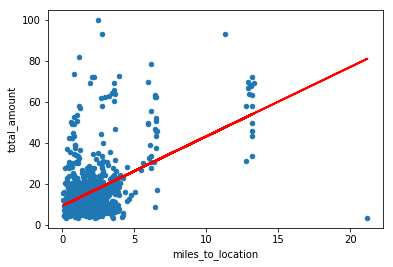

In [15]:
# plot data and least squares for data
taxi_df.plot(kind='scatter', x='miles_to_location', y='total_amount')
X = taxi_df['miles_to_location']
Y = lm.predict(X)
plt.plot(X, Y, c='red', linewidth=2)

## To make this analysis meaningful you would need to examine trips with similar geospatial distance. 
## How would you limit the data to trips of a certain distance range?